In [1]:
#from __future__ import print_function

import numpy as np
import pandas as pd
import random
import datetime
import re
random.seed(2010)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras_tqdm import TQDMCallback, TQDMNotebookCallback


Using TensorFlow backend.


In [2]:
Data = pd.read_csv('data/marathon_results_2015.csv')[['M/F','Age','Official Time']]
def convertToSeconds(t):
    h,m,s = re.split(':',t)
    return int(datetime.timedelta(hours=int(h),minutes=int(m),seconds=int(s)).total_seconds())

Data['Official Time'] = Data['Official Time'].apply(convertToSeconds)
Data

,M/F,Age,Official Time
0,M,25,7757
1,M,30,7788
2,M,29,7822
3,M,28,7847
4,M,32,7849
5,M,30,7852
6,M,32,7880
7,M,39,7962
8,M,27,8015
9,M,33,8032


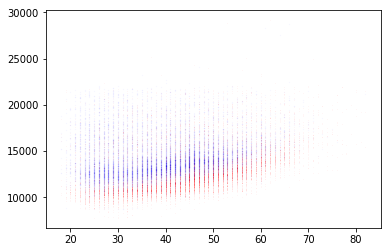

In [3]:
Males = Data[Data['M/F']=='M']
Females = Data[Data['M/F']=='F']

plt.plot(Males['Age'],Males['Official Time'],'xr',ms= .01)
plt.plot(Females['Age'],Females['Official Time'],'sb',ms= .01)


In [13]:
#################################
#######Construct Network#########
#################################

# Define sudoMin loss function


# Convolutional layers

# Example from Keras github


batch_size = 128
no_predictions = 2
epochs = 10000


def customLoss(yTrue,yPred):
    ratio = .0001
    return K.sum(K.min(K.abs(yTrue-yPred),axis = 1))+ ratio*K.sum(K.sum(K.square(yTrue-yPred),axis = 1),axis = 0)



sample_ratio = .99

Train, Test  = train_test_split(Data[['Age','Official Time']], train_size = .04,test_size = .01)
x_train,y_train = Train['Age'],Train['Official Time'] 
x_test,y_test = Test['Age'],Test['Official Time'] 
# the data, split between train and test sets

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices


model = Sequential()
model.add(Dense(64, activation='relu',
                kernel_initializer='random_uniform', bias_initializer='zeros',
                input_shape=[1]))
model.add(Dense(64, activation='relu',
                kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dense(32, activation='relu',
                kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dense(no_predictions, activation='linear'))

model.compile(loss=customLoss,
              optimizer=keras.optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])

x_train shape: (1063,)
1063 train samples
266 test samples
Test loss: 74634.83666441495


Text(0.5,1,'Multimodal Output, Toy Results')

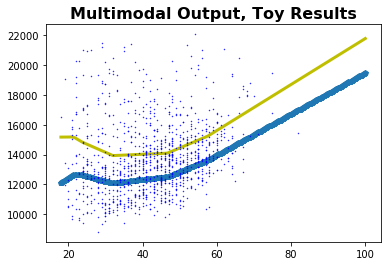

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.linspace(18, 100, 200)
Y1,Y2 = zip(*model.predict(X))
#Y1,Y2,Y3,Y4 = zip(*model.predict(X))

plt.scatter(x_train, y_train,s = .2, c='blue',zorder=2)
#plt.scatter(x_test, y_test, s = .2 ,c='black',zorder=2)


plt.plot(X,Y1, 'p-',linewidth = 3,zorder=1)
plt.plot(X,Y2, 'y-',linewidth = 3,zorder=1)
#plt.plot(X,Y3, 'b-',linewidth = 3)
#plt.plot(X,Y4, 'y-',linewidth = 3)

#plt.ylim(0,300)
# Add title and x, y labels
plt.title("Multimodal Output, Toy Results", fontsize=16, fontweight='bold')


In [15]:
Y1,Y2 = zip(*model.predict(Data['Age']))
Data['Res1'] = np.abs(Data['Official Time'] - Y1)
Data['Res2'] = np.abs(Data['Official Time'] - Y2)
Data['Cluster'] = Data['Res1']<Data['Res2']

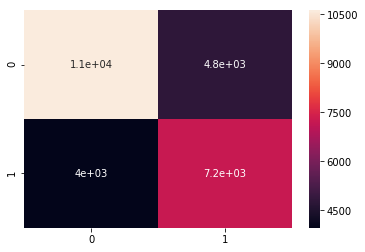

In [16]:
import seaborn as sn
C1 = ((Data['Res1'] < Data['Res2']) & (Data['M/F'] == 'M')).sum()
C2 = ((Data['Res1'] < Data['Res2']) & (Data['M/F'] == 'F')).sum()
C3 = ((Data['Res1'] >= Data['Res2']) & (Data['M/F'] == 'M')).sum()
C4 = ((Data['Res1'] >= Data['Res2']) & (Data['M/F'] == 'F')).sum()


sn.heatmap([[C1,C2],[C3,C4]], annot=True)


In [32]:
Data['Res1']

0         8327.498047
1         8373.194336
2         8404.255859
3         8426.316406
4         8440.074219
5         8437.194336
6         8471.074219
7         8573.649414
8         8591.376953
9         8626.013672
10        8626.013672
11        8642.194336
12        8776.074219
13        8870.134766
14        8944.467773
15        8934.255859
16        8942.194336
17        8983.316406
18        9004.316406
19        9008.437500
20        9033.074219
21        9043.437500
22        9067.074219
23        9097.316406
24        9116.074219
25        9141.074219
26        9183.255859
27        9291.588867
28        9275.074219
29        9321.225586
             ...     
26568    22731.619141
26569    22678.710938
26570    22728.740234
26571    22714.103516
26572    22667.195312
26573    22743.679688
26574    22853.650391
26575    22880.376953
26576    23002.195312
26577    22945.589844
26578    22977.285156
26579    22980.376953
26580    23151.013672
26581    23257.589844
26582    2